In [ ]:
! pip install transformers
! pip install sacremoses

In [ ]:
import pandas as pd

file_name = 'GDT_data_v01.xlsx'
df = pd.read_excel(io=file_name)

model_names = {
    "herbert-klej-cased-v1": {
        "tokenizer": "allegro/herbert-klej-cased-tokenizer-v1",
        "model": "allegro/herbert-klej-cased-v1",
    },
    "herbert-base-cased": {
        "tokenizer": "allegro/herbert-base-cased",
        "model": "allegro/herbert-base-cased",
    },
    "herbert-large-cased": {
        "tokenizer": "allegro/herbert-large-cased",
        "model": "allegro/herbert-large-cased",
    },
}

In [ ]:
from typing import Callable, List, Optional, Tuple
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        tokenized_text = self.bert_tokenizer.encode_plus(text,
                                                         add_special_tokens=True,
                                                         max_length=self.max_length
                                                         )["input_ids"]

        attention_mask = [1] * len(tokenized_text)

        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.bert_model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        return self


In [ ]:
import numpy as np
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_names["herbert-base-cased"]["tokenizer"])
model = AutoModel.from_pretrained(model_names["herbert-base-cased"]["model"]) 
bert_transformer = BertTransformer(tokenizer, model)

In [181]:
from sklearn.model_selection import train_test_split

working_df = df[~df['nlp_5'].isna()]
df_train, df_test = train_test_split(working_df, test_size = 0.2, random_state=23)

In [182]:
train_x = df_train['nlp_5']
train_y = df_train['GDT_score']
test_x = df_test['nlp_5']
test_y = df_test['GDT_score']

In [ ]:
tokenized_train_x = bert_transformer.transform(train_x)

In [186]:
from sklearn import svm
vector_regression = svm.SVR(kernel='linear')
vector_regression.fit(tokenized_train_x, train_y)

SVR(kernel='linear')

In [188]:
tokenized_test_x = bert_transformer.transform(test_x)

In [190]:
result = vector_regression.predict(tokenized_test_x)

In [192]:
from scipy import stats
print(stats.pearsonr(result, test_y))

(0.2554124793514868, 0.012020422940074915)


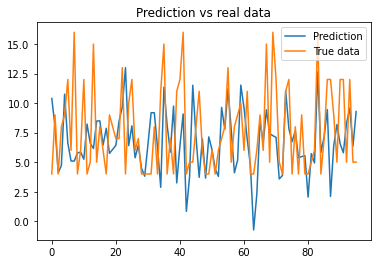

In [193]:
import matplotlib.pyplot as plt

plt.plot(range(96), result, label="Prediction")
plt.plot(range(96), test_y, label='True data')
plt.legend(loc='upper right')
plt.title('Prediction vs real data')
plt.show()